In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

class IntegrateAndFireNeuron:
    def __init__(self, C=1.0, g_L=0.1, E_L=-70, V_th=-63, V_max=30):
        # Model parameters
        self.C = C  # Membrane capacitance (μF)
        self.g_L = g_L  # Membrane conductance (μS)
        self.E_L = E_L  # Reversal potential (mV)
        self.V_th = V_th  # Spike threshold (mV)
        self.V_max = V_max  # Maximum voltage during spike (mV)
        
    def simulate_passive(self, I, T=100, dt=1.0, noise_sigma=0):
        """Simulate passive membrane dynamics"""
        # Initialize time and voltage arrays
        t = np.arange(0, T, dt)
        V = np.zeros_like(t)
        V[0] = self.E_L
        
        # Simulation loop
        for i in range(len(t)-1):

            # Calculate dV/dt
            dV = (self.g_L * (self.E_L - V[i]) + I) / self.C
            
            # Add noise if specified
            if noise_sigma > 0:
                noise = noise_sigma * np.random.normal(0, 1) * np.sqrt(dt)
                dV += noise / self.C
            
            # Euler integration
            V[i+1] = V[i] + dV * dt
            
        return t, V
    
    def simulate_spiking(self, I, T=100, dt=1.0, noise_sigma=0, time_varying = False):
        """Simulate membrane dynamics with spiking mechanism"""
        t = np.arange(0, T, dt)
        V = np.zeros_like(t)
        V[0] = self.E_L
        spike_times = []
        
        for i in range(len(t)-2):

            if time_varying:
                dV = (self.g_L * (self.E_L - V[i]) + I[i]) / self.C
            else:
                dV = (self.g_L * (self.E_L - V[i]) + I) / self.C
            

            
            if noise_sigma > 0:
                noise = noise_sigma * np.random.normal(0, 1) * np.sqrt(dt)
                dV += noise / self.C


            # Spike generation
            if V[i] >= self.V_th:
                V[i] = self.V_max  # Show spike
                spike_times.append(t[i+1])
                V[i+1] = self.E_L  # Reset
            else:
            
                V[i+1] = V[i] + dV * dt
            

        return t, V, spike_times

                    
    def find_firing_rate(self, I_range):
        """Calculate firing rate for different input currents"""
        rates = []
        for I in I_range:
            _, _, spikes = self.simulate_spiking(I)
            rates.append(len(spikes))
        return rates

# Q1.1

In [10]:
neuron = IntegrateAndFireNeuron()

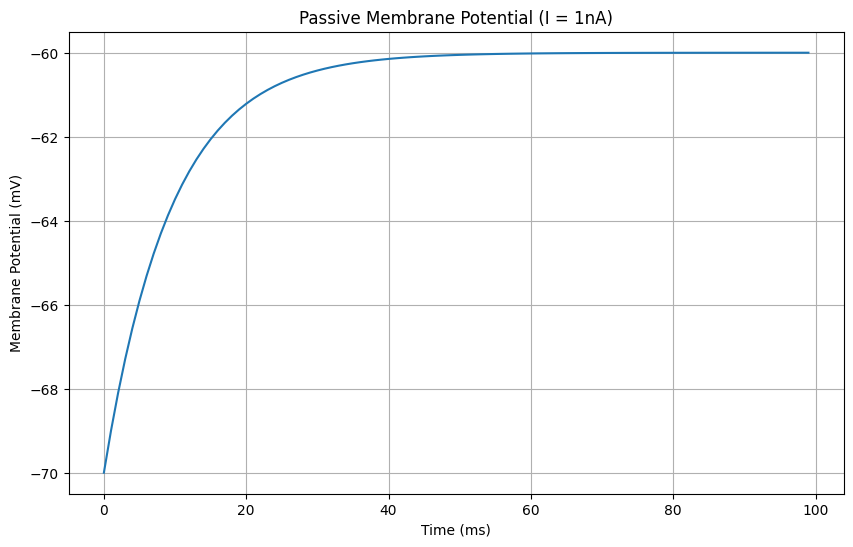

In [37]:
# neuron = IntegrateAndFireNeuron()

t, V = neuron.simulate_passive(I=1.0)
plt.figure(figsize=(10, 6))
plt.plot(t, V)
plt.title('Passive Membrane Potential (I = 1nA)')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.grid(True)
plt.savefig('./latex/fig1.png')
plt.show()

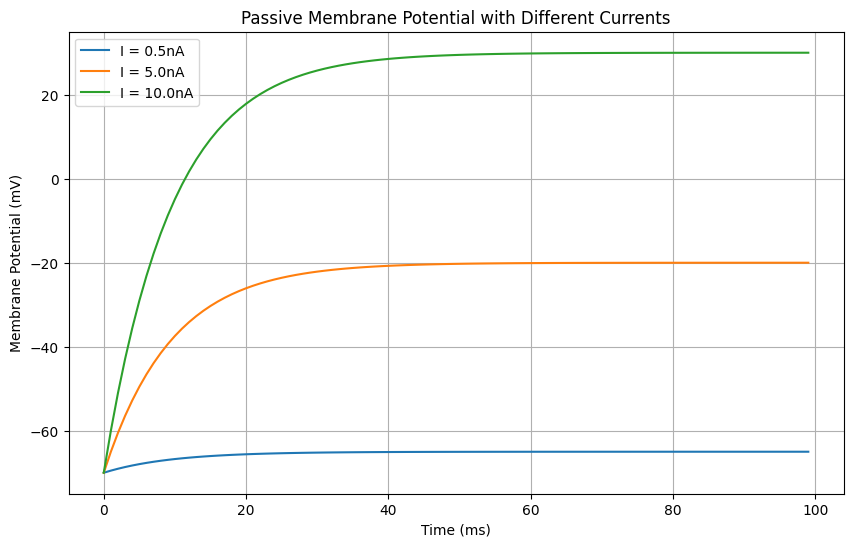

In [40]:
# 1.2 Different current values
currents = [0.5, 5.0, 10.0]
plt.figure(figsize=(10, 6))
for I in currents:
    t, V = neuron.simulate_passive(I)
    plt.plot(t, V, label=f'I = {I}nA')
plt.title('Passive Membrane Potential with Different Currents')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.legend()
plt.grid(True)
plt.savefig('./latex/fig2.png')
plt.show()

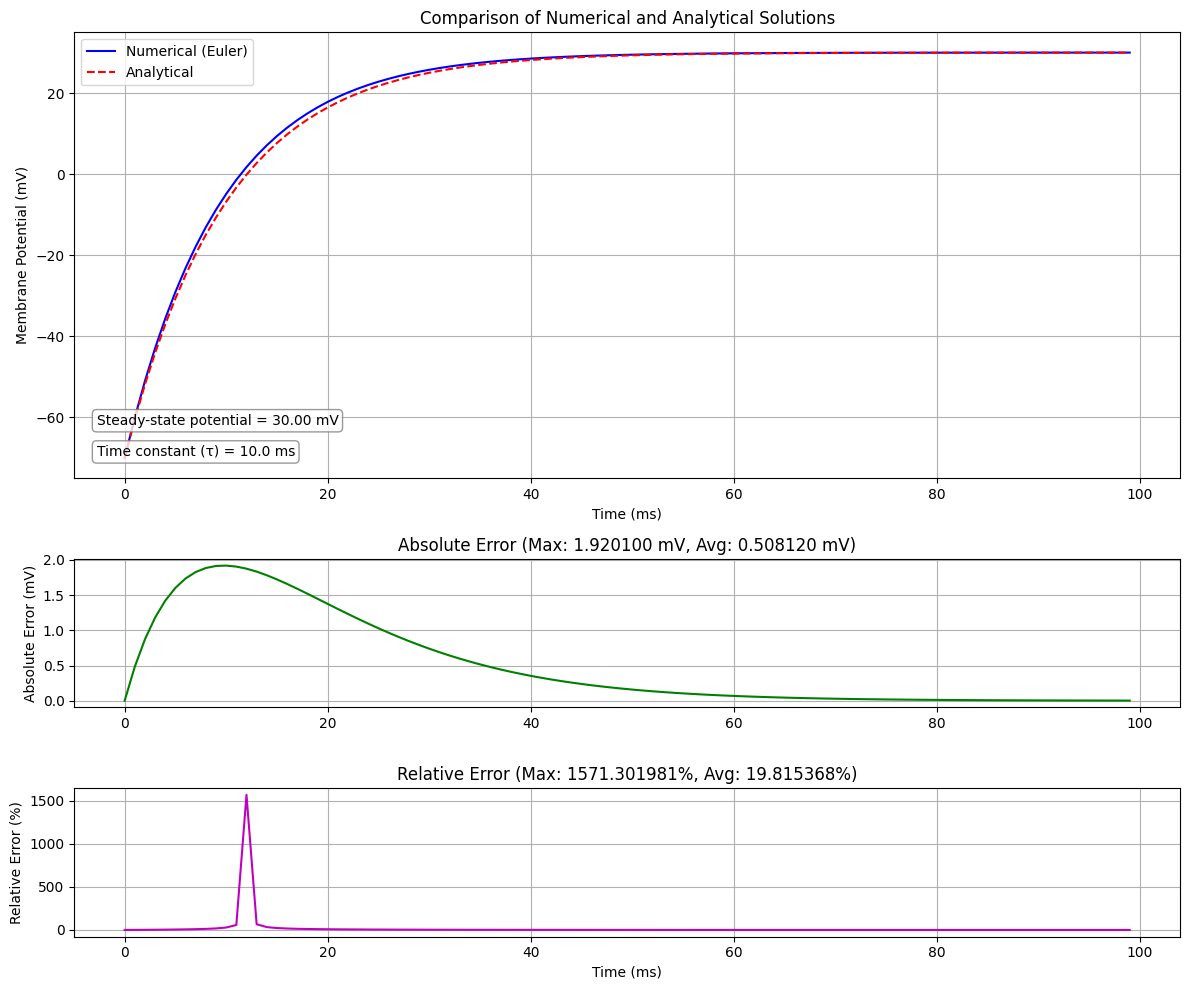

Parameters:
  Membrane capacitance (C) = 1.0 μF
  Leak conductance (gL) = 0.1 μS
  Leak reversal potential (EL) = -70.0 mV
  Input current (I) = 10.0 nA
  Time step (dt) = 1.0 ms
Derived quantities:
  Membrane time constant (τ = C/gL) = 10.0 ms
  Steady-state potential (EL + I/gL) = 30.0 mV
Error metrics:
  Maximum absolute error = 1.92010011 mV
  Average absolute error = 0.50812048 mV
  Maximum relative error = 1571.30198078%
  Average relative error = 19.81536807%


In [42]:
# Analytical solution
def analytical_solution(I, t):
    """
    Analytical solution for the passive membrane ODE:
    C * dV/dt = gL * (EL - V) + I
    
    The solution is V(t) = EL + (I/gL) * (1 - exp(-t/tau))
    where tau = C/gL is the membrane time constant
    """
    tau = C / gL  # Time constant (ms)
    V_inf = EL + (I / gL)  # Steady-state potential (mV)
    return EL + (V_inf - EL) * (1 - np.exp(-t / tau))

# Calculate solutions
_, V_numerical = neuron.simulate_passive(I)
V_analytical = analytical_solution(I, time)

# Calculate the error between the two solutions
absolute_error = np.abs(V_numerical - V_analytical)
relative_error = absolute_error / np.abs(V_analytical) * 100  # in percentage

# Calculate key metrics
tau = C / gL  # Time constant (ms)
V_inf = EL + (I / gL)  # Steady-state potential (mV)
max_abs_error = np.max(absolute_error)
avg_abs_error = np.mean(absolute_error)
max_rel_error = np.max(relative_error)
avg_rel_error = np.mean(relative_error)

# Create a detailed figure
plt.figure(figsize=(12, 10))
gs = GridSpec(3, 1, height_ratios=[3, 1, 1])

# Plot both solutions
ax1 = plt.subplot(gs[0])
ax1.plot(time, V_numerical, 'b-', label='Numerical (Euler)')
ax1.plot(time, V_analytical, 'r--', label='Analytical')
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Membrane Potential (mV)')
ax1.set_title('Comparison of Numerical and Analytical Solutions')
ax1.legend()
ax1.grid(True)

# Add annotations for key parameters
ax1.annotate(f'Time constant (τ) = {tau} ms', xy=(0.02, 0.05), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
ax1.annotate(f'Steady-state potential = {V_inf:.2f} mV', xy=(0.02, 0.12), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Plot absolute error
ax2 = plt.subplot(gs[1], sharex=ax1)
ax2.plot(time, absolute_error, 'g-')
ax2.set_ylabel('Absolute Error (mV)')
ax2.set_title(f'Absolute Error (Max: {max_abs_error:.6f} mV, Avg: {avg_abs_error:.6f} mV)')
ax2.grid(True)

# Plot relative error
ax3 = plt.subplot(gs[2], sharex=ax1)
ax3.plot(time, relative_error, 'm-')
ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Relative Error (%)')
ax3.set_title(f'Relative Error (Max: {max_rel_error:.6f}%, Avg: {avg_rel_error:.6f}%)')
ax3.grid(True)

plt.tight_layout()
plt.savefig('./latex/fig3.png', dpi=300)

plt.show()

print(f"Parameters:")
print(f"  Membrane capacitance (C) = {C} μF")
print(f"  Leak conductance (gL) = {gL} μS")
print(f"  Leak reversal potential (EL) = {EL} mV")
print(f"  Input current (I) = {I} nA")
print(f"  Time step (dt) = {dt} ms")
print(f"Derived quantities:")
print(f"  Membrane time constant (τ = C/gL) = {tau} ms")
print(f"  Steady-state potential (EL + I/gL) = {V_inf} mV")
print(f"Error metrics:")
print(f"  Maximum absolute error = {max_abs_error:.8f} mV")
print(f"  Average absolute error = {avg_abs_error:.8f} mV")
print(f"  Maximum relative error = {max_rel_error:.8f}%")
print(f"  Average relative error = {avg_rel_error:.8f}%")

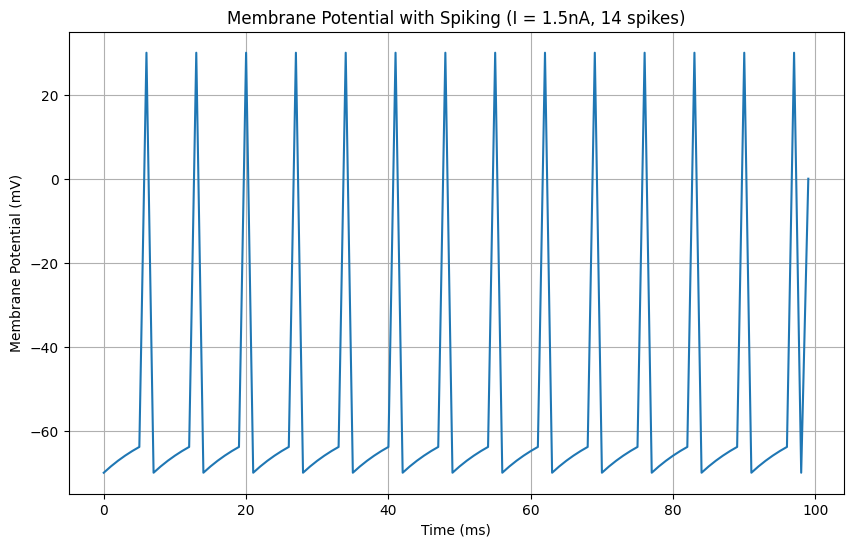

In [ ]:
# 1.4 & 1.5 Spiking mechanism
t, V, spikes = neuron.simulate_spiking(I=1.5)
plt.figure(figsize=(10, 6))
plt.plot(t, V)
plt.title(f'Membrane Potential with Spiking (I = 1.5nA, {len(spikes)} spikes)')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.grid(True)
plt.savefig('./latex/fig4.png')
plt.show()


In [48]:
np.linspace(0, 3, 30)

array([0.        , 0.10344828, 0.20689655, 0.31034483, 0.4137931 ,
       0.51724138, 0.62068966, 0.72413793, 0.82758621, 0.93103448,
       1.03448276, 1.13793103, 1.24137931, 1.34482759, 1.44827586,
       1.55172414, 1.65517241, 1.75862069, 1.86206897, 1.96551724,
       2.06896552, 2.17241379, 2.27586207, 2.37931034, 2.48275862,
       2.5862069 , 2.68965517, 2.79310345, 2.89655172, 3.        ])

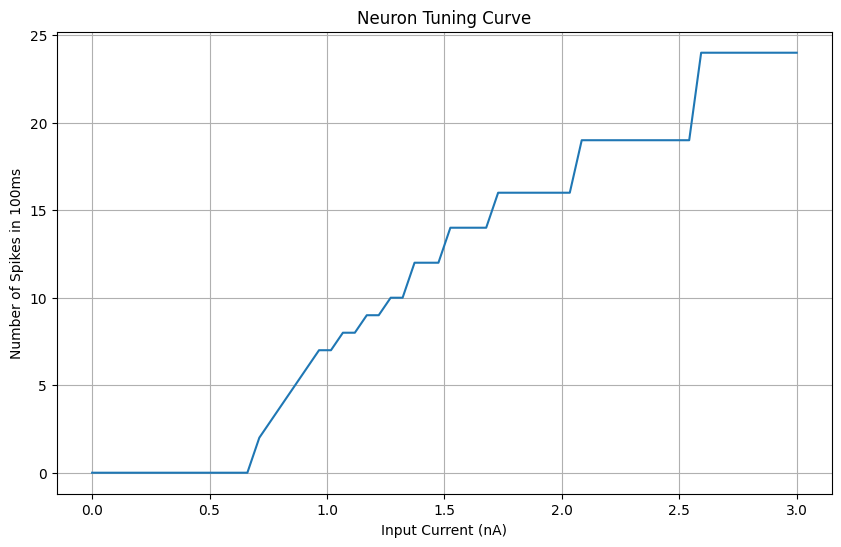

In [52]:
# Tuning curve
I_range = np.linspace(0, 3, 60)
rates = neuron.find_firing_rate(I_range)
plt.figure(figsize=(10, 6))
plt.plot(I_range, rates)
plt.title('Neuron Tuning Curve')
plt.xlabel('Input Current (nA)')
plt.ylabel('Number of Spikes in 100ms')

plt.savefig('./latex/fig5.png')

plt.grid(True)

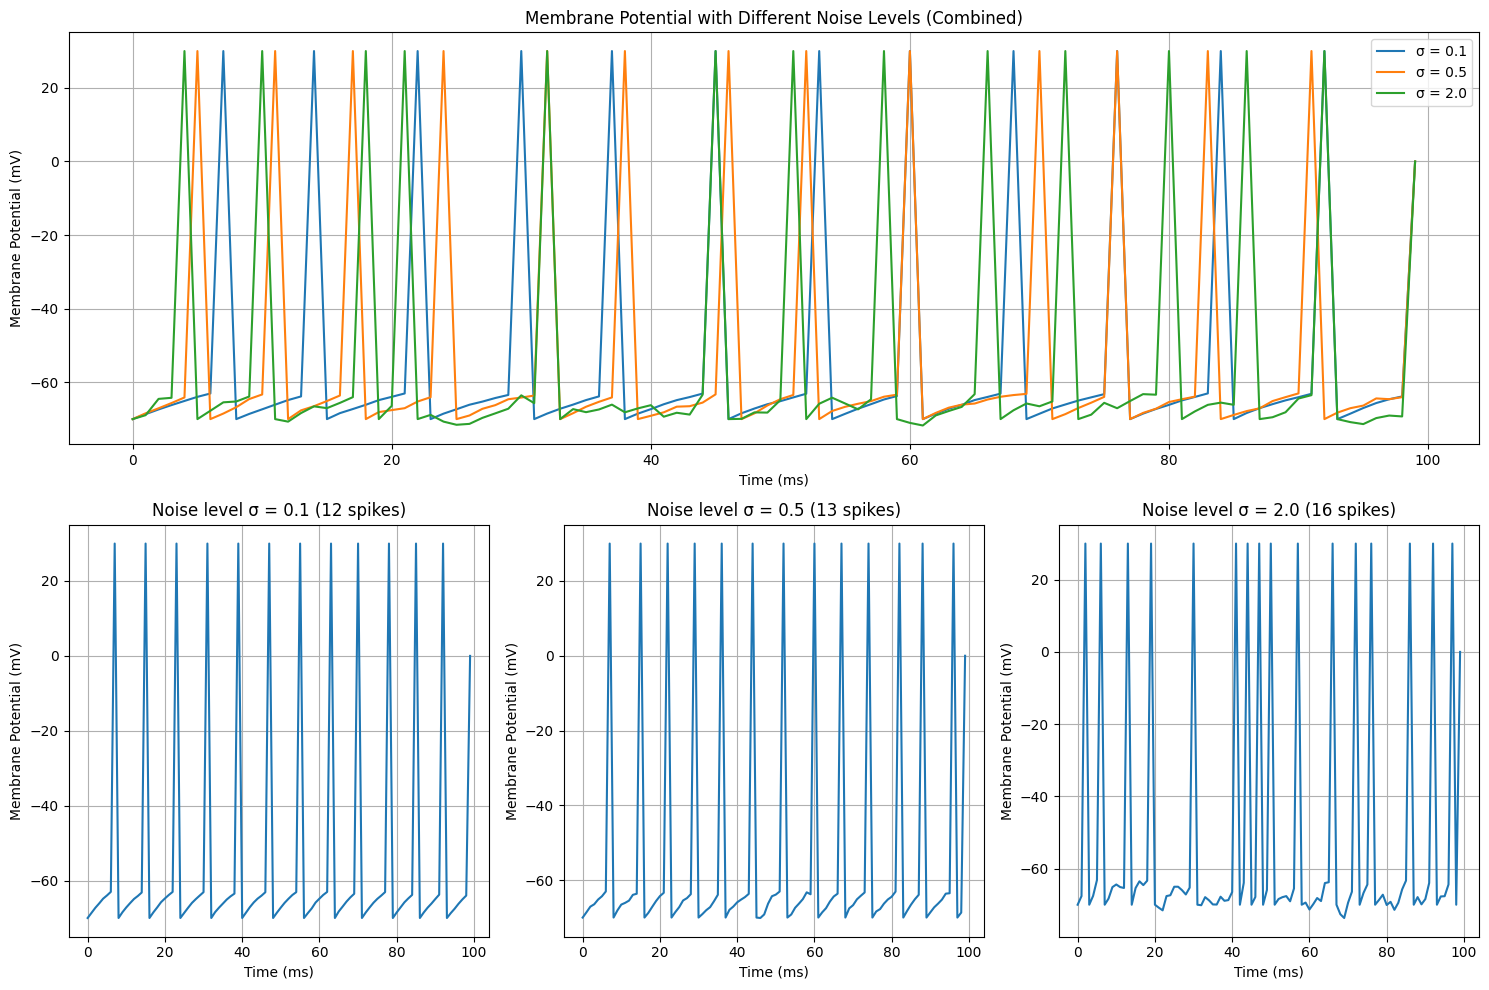

In [62]:

# 1.6 With noise
# 1.6 With noise
noise_levels = [0.1, 0.5, 2.0] # nA

plt.figure(figsize=(15, 10))

# First plot: all noise levels on one graph for comparison
plt.subplot(2, 1, 1)
for noise in noise_levels:
    t, V, spikes = neuron.simulate_spiking(I=1.5, noise_sigma=noise)
    plt.plot(t, V, label=f'σ = {noise}')
plt.title('Membrane Potential with Different Noise Levels (Combined)')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.legend()
plt.grid(True)

# Individual subplots for each noise level
for i, noise in enumerate(noise_levels):
    plt.subplot(2, 3, i+4)
    t, V, spikes = neuron.simulate_spiking(I=1.5, noise_sigma=noise)
    plt.plot(t, V)
    plt.title(f'Noise level σ = {noise} ({len(spikes)} spikes)')
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane Potential (mV)')
    plt.grid(True)

plt.savefig('./latex/fig6.png')

plt.tight_layout()
plt.show()

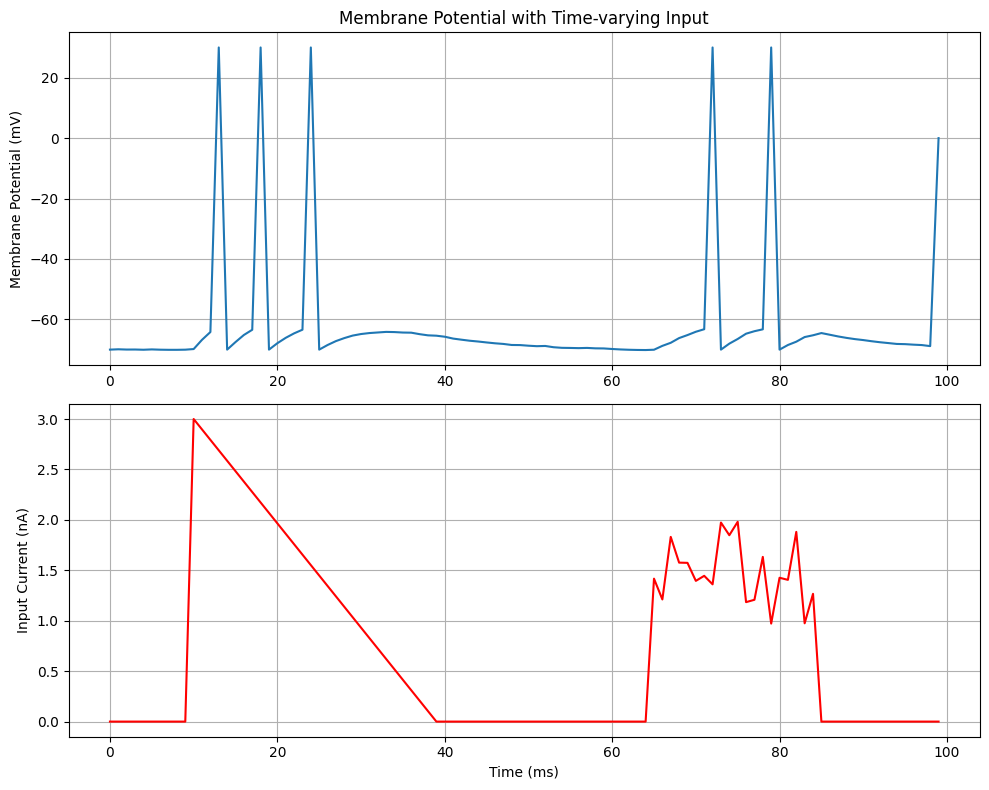

In [71]:
# 1.7 Time-varying input
T = 100
I_t = np.zeros(T)
# I_t[45:50] = 2.0  # Input pulse from 20ms to 60ms
I_t[65:85] = 1.5 + np.random.normal(0, 0.5, 20) # Input pulse from 20ms to 60ms
# adding a noise

# Input linearly decreases from 5nA to 0nA from 80ms to 100ms
I_t[10:40] = np.linspace(3, 0, 30)

t = np.arange(T)
neuron = IntegrateAndFireNeuron()

_, V, _ = neuron.simulate_spiking(I_t, noise_sigma=0.1, time_varying=True)

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(t, V)
plt.title('Membrane Potential with Time-varying Input')
plt.ylabel('Membrane Potential (mV)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t, I_t, 'r')
plt.xlabel('Time (ms)')
plt.ylabel('Input Current (nA)')
plt.grid(True)
plt.tight_layout()

plt.savefig('./latex/fig7.png')
plt.show()

In [ ]:
class HodgkinHuxleyModel:
    def __init__(self):
        # Model parameters
        self.C = 1.0  # Membrane capacitance (μF/cm²)
        self.g_L = 0.3  # Leak conductance (mS/cm²)
        self.E_L = -54.4  # Leak reversal potential (mV)
        self.g_K = 36.0  # Potassium conductance (mS/cm²)
        self.E_K = -77.0  # Potassium reversal potential (mV)
        self.g_Na = 120.0  # Sodium conductance (mS/cm²)
        self.E_Na = 50.0  # Sodium reversal potential (mV)
        
    def alpha_n(self, V):
        return 0.01 * (V + 55) / (1 - np.exp(-0.1 * (V + 55)))
    
    def beta_n(self, V):
        return 0.125 * np.exp(-0.0125 * (V + 65))
    
    def alpha_m(self, V):
        return 0.1 * (V + 40) / (1 - np.exp(-0.1 * (V + 40)))
    
    def beta_m(self, V):
        return 4 * np.exp(-0.0556 * (V + 65))
    
    def alpha_h(self, V):
        return 0.07 * np.exp(-0.05 * (V + 65))
    
    def beta_h(self, V):
        return 1 / (1 + np.exp(-0.1 * (V + 35)))
    
    def simulate(self, I, T=100, dt=0.01):
        """
        Simulate Hodgkin-Huxley model
        
        Parameters:
        I: Injected current (nA)
        T: Simulation time (ms)
        dt: Time step (ms)
        
        Returns:
        t: Time points
        V: Membrane potential
        n, m, h: Channel variables
        """
        # Number of time steps
        steps = int(T / dt)
        
        # Initialize arrays
        t = np.arange(0, T, dt)
        V = np.zeros(steps)
        n = np.zeros(steps)
        m = np.zeros(steps)
        h = np.zeros(steps)
        
        # Initial conditions
        V[0] = self.E_L
        
        # Initialize n, m, h to their steady state values at resting potential
        n[0] = self.alpha_n(V[0]) / (self.alpha_n(V[0]) + self.beta_n(V[0]))
        m[0] = self.alpha_m(V[0]) / (self.alpha_m(V[0]) + self.beta_m(V[0]))
        h[0] = self.alpha_h(V[0]) / (self.alpha_h(V[0]) + self.beta_h(V[0]))
        
        # Ensure I is an array (for time-varying current)
        if isinstance(I, (int, float)):
            I_array = np.ones(steps) * I
        else:
            I_array = I
            
        # Simulation loop
        for i in range(steps-1):
            # Channel dynamics
            dn = self.alpha_n(V[i]) * (1 - n[i]) - self.beta_n(V[i]) * n[i]
            dm = self.alpha_m(V[i]) * (1 - m[i]) - self.beta_m(V[i]) * m[i]
            dh = self.alpha_h(V[i]) * (1 - h[i]) - self.beta_h(V[i]) * h[i]
            
            # Update channel variables using Euler method
            n[i+1] = n[i] + dt * dn
            m[i+1] = m[i] + dt * dm
            h[i+1] = h[i] + dt * dh
            
            # Membrane potential dynamics
            I_L = self.g_L * (self.E_L - V[i])
            I_K = self.g_K * (n[i]**4) * (self.E_K - V[i])
            I_Na = self.g_Na * (m[i]**3) * h[i] * (self.E_Na - V[i])
            
            dV = (I_L + I_K + I_Na + I_array[i]) / self.C
            
            # Update membrane potential
            V[i+1] = V[i] + dt * dV
            
        return t, V, n, m, h
    
    def find_threshold(self, I_min=0, I_max=10, steps=50, T=200):
        """Find the threshold current for repetitive spiking"""
        currents = np.linspace(I_min, I_max, steps)
        spikes_per_current = []
        
        for I in currents:
            t, V, _, _, _ = self.simulate(I, T=T)
            
            # Count spikes (voltage crosses 0 mV from below)
            spikes = 0
            for i in range(1, len(V)):
                if V[i-1] < 0 and V[i] >= 0:
                    spikes += 1
            
            spikes_per_current.append(spikes)
            
        return currents, spikes_per_current


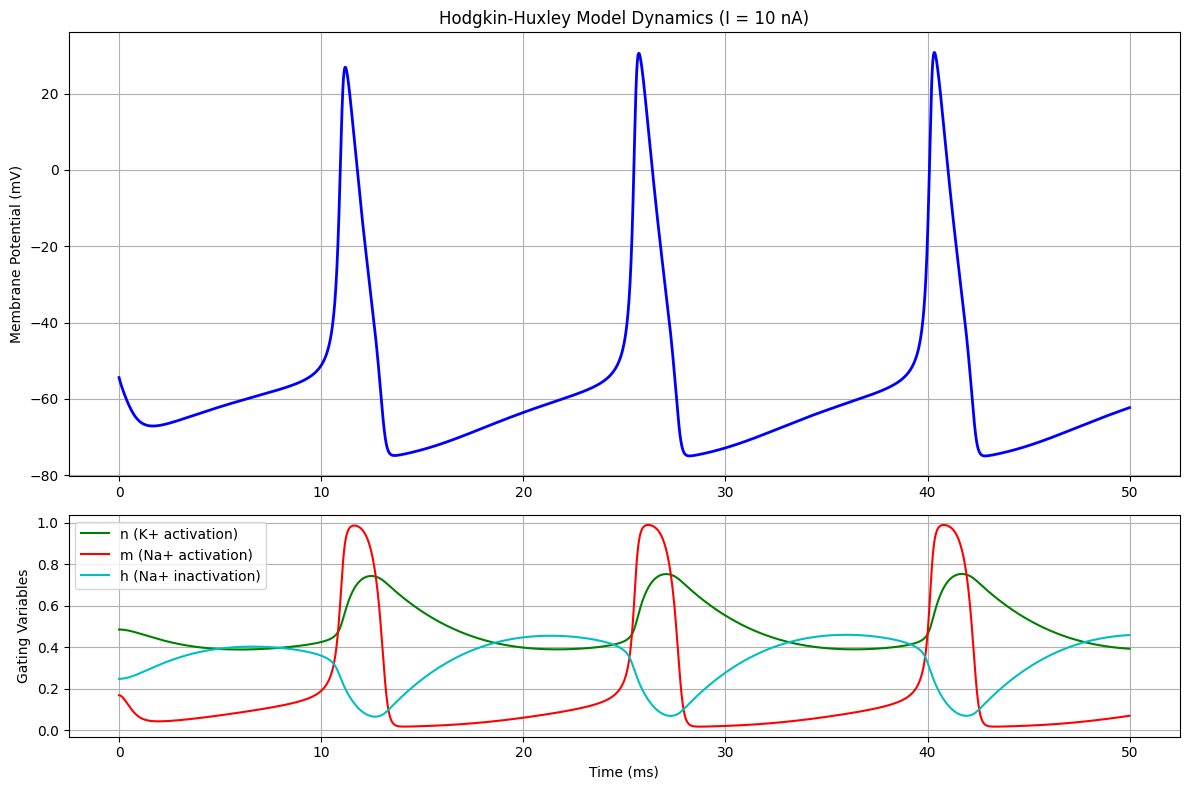

In [72]:
model = HodgkinHuxleyModel()

# 2.1 Simulate HH dynamics with a current that causes spiking
t, V, n, m, h = model.simulate(I=10, T=50)

# Create a plot with subplots
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 1, height_ratios=[2, 1])

# Membrane potential
ax1 = fig.add_subplot(gs[0])
ax1.plot(t, V, 'b', linewidth=2)
ax1.set_title('Hodgkin-Huxley Model Dynamics (I = 10 nA)')
ax1.set_ylabel('Membrane Potential (mV)')
ax1.grid(True)

# Channel variables
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.plot(t, n, 'g', label='n (K+ activation)')
ax2.plot(t, m, 'r', label='m (Na+ activation)')
ax2.plot(t, h, 'c', label='h (Na+ inactivation)')
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Gating Variables')
ax2.legend()
ax2.grid(True)

plt.savefig('./latex/fig8.png')
plt.tight_layout()
plt.show()

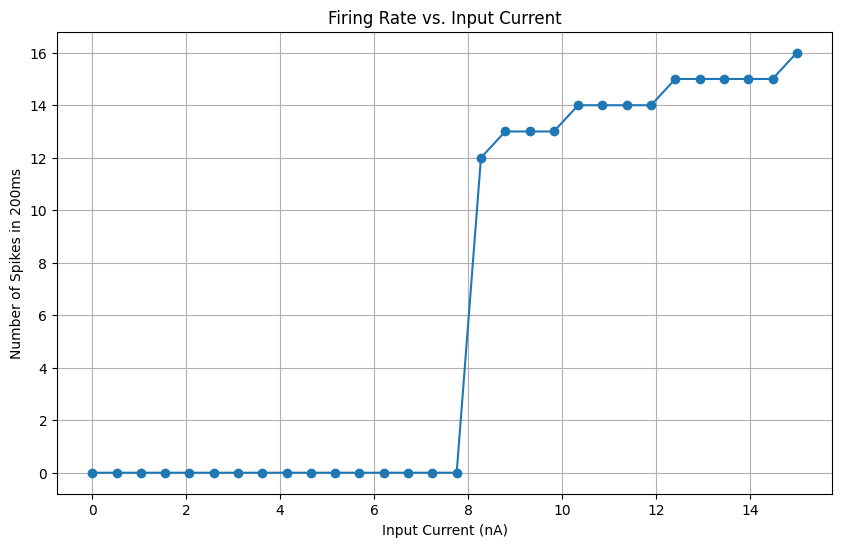

In [74]:
# 2.2 Vary current to find spiking threshold
currents, spikes = model.find_threshold(I_min=0, I_max=15, steps=30, T=200)

plt.figure(figsize=(10, 6))
plt.plot(currents, spikes, 'o-')
plt.title('Firing Rate vs. Input Current')
plt.xlabel('Input Current (nA)')
plt.ylabel('Number of Spikes in 200ms')
plt.grid(True)
plt.savefig('./latex/fig9.png')
plt.show()


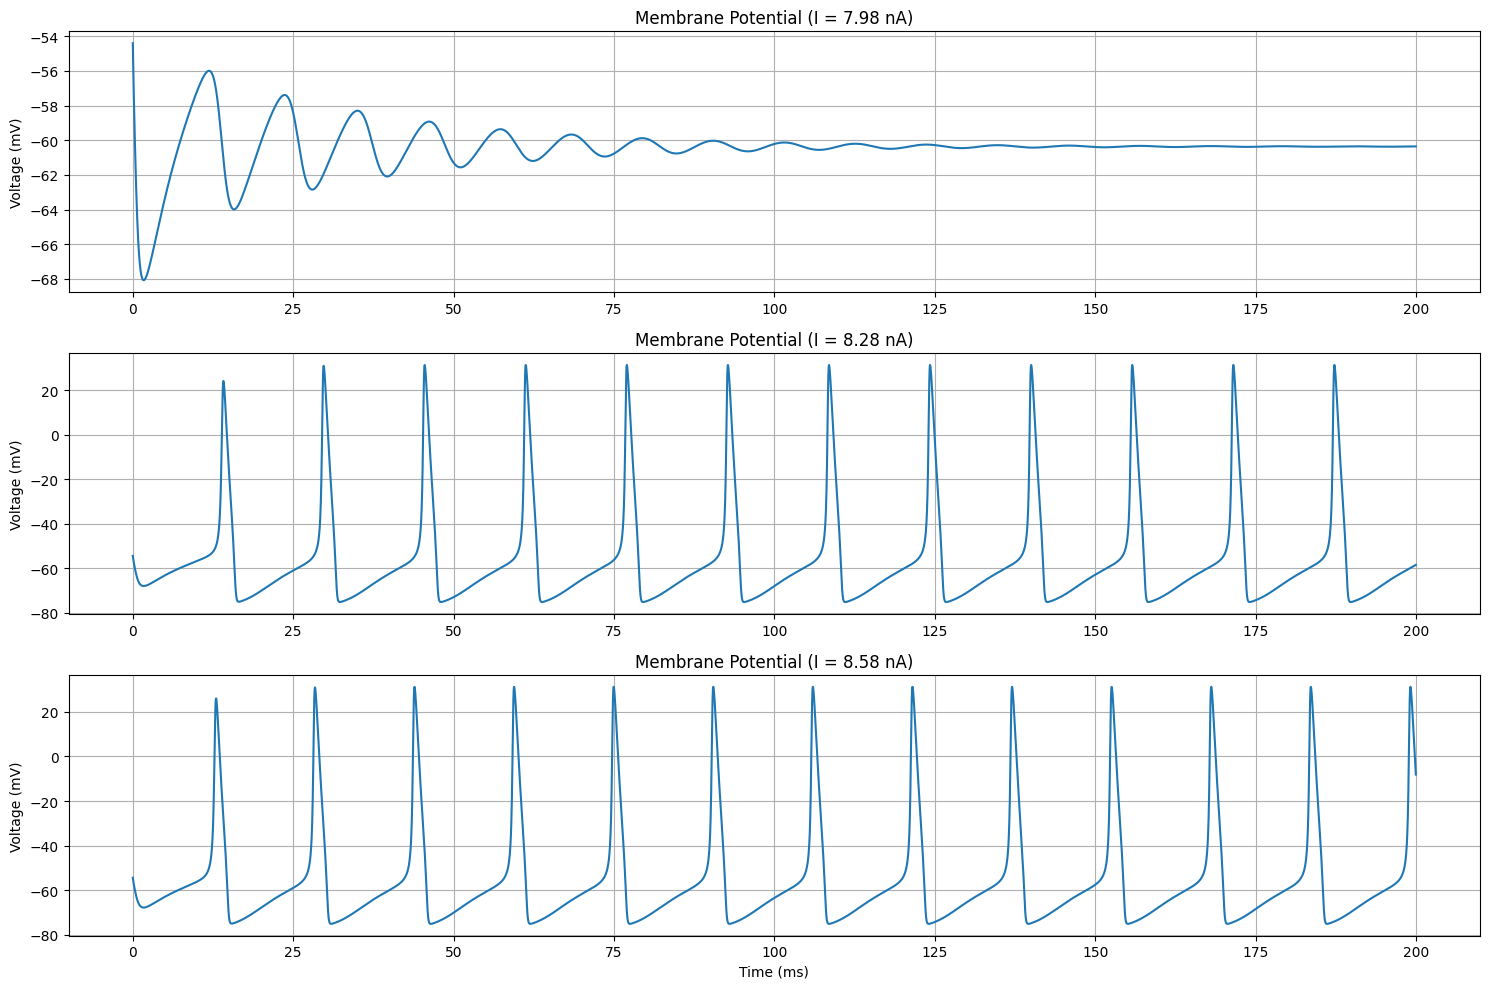

In [76]:
# Plot near threshold behavior
# Find approximate threshold
threshold_idx = next((i for i, s in enumerate(spikes) if s > 0), -1)
if threshold_idx > 0:
    threshold_current = currents[threshold_idx]
    
    # Plot dynamics just below, at, and just above threshold
    plt.figure(figsize=(15, 10))
    
    currents_near_threshold = [
        threshold_current - 0.3,
        threshold_current,
        threshold_current + 0.3
    ]
    
    for i, I in enumerate(currents_near_threshold):
        t, V, n, m, h = model.simulate(I, T=200)
        
        plt.subplot(3, 1, i+1)
        plt.plot(t, V)
        plt.title(f'Membrane Potential (I = {I:.2f} nA)')
        plt.ylabel('Voltage (mV)')
        if i == 2:
            plt.xlabel('Time (ms)')
        plt.grid(True)
    
    plt.tight_layout()
    # plt.show()

plt.savefig('./latex/fig10.png')